### Protein Family Classification

In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [57]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [58]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [59]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [60]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_YEFVE,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [61]:
NUMBER_OF_FAMILIES = 500
MAX_PROTEIN_LENGTH = 500
def get_families(size=NUMBER_OF_FAMILIES):
    counter = {}
    for id in family_classification_metadata["FamilyID"]:
        if id not in counter:
            counter[id] = 0
        counter[id] += 1
    
    sorted_families = sorted(counter, key=counter.__getitem__, reverse=True)
    return sorted_families[:size]
            

In [62]:
families = get_families()
families_map = {fam: i for i, fam in enumerate(families)}

In [63]:
def process_prot2vec_from_article():
    res_dict = {}
    for line in pd.read_csv('../seminar_6/data/protVec_100d_3grams.csv').as_matrix():
        split_line = line[0].split()
        res_dict[split_line[0]] = np.array([float(x) for x in split_line[1:]])
    return res_dict

In [64]:
prot2vec = process_prot2vec_from_article()

In [65]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUMBER_OF_FAMILIES])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [66]:
def parse(protein):
    embedded = []
    for i in range(0, len(protein) - 3, 3):
        try:
            embedded.append(prot2vec[protein[i:i+3]])
        except KeyError:
            embedded.append(prot2vec['<unk>'])
    return np.array(embedded)
    
class Embedding:
    def __init__(self, length, parser=parse):
        self.parser = parser
        self._length = length
        self.dimensions = 100
        
    def __call__(self, protein):
        embedded = self.parser(protein)
        if len(embedded) < self._length:
            embedded = np.vstack((embedded, np.zeros(shape=(self._length - embedded.shape[0], self.dimensions))))
        return np.array(embedded)

In [67]:
proteins = np.array(family_classification_sequences['Sequences'])
families = np.array(family_classification_metadata['FamilyID'])

length = MAX_PROTEIN_LENGTH

embedding = Embedding(length)

In [68]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=256,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embedding.dimensions
)

In [69]:
def build_target(family):
    return np.eye(NUMBER_OF_FAMILIES)[families_map[family]]
    
def preprocess_batched(iterator, length, embedding, batch_size):
    while True:
        data = []
        target = []
        for index in range(batch_size):
            try:
                protein, family = next(iterator)
            except:
                return
            data.append(embedding(protein))
            target.append(build_target(family))
        yield np.array(data), np.array(target)

In [70]:
valid_indices = []
for i,f in enumerate(families):
    if f not in families_map or len(proteins[i]) > MAX_PROTEIN_LENGTH:
        continue
    valid_indices.append(i)
valid_indices = np.array(valid_indices)
np.random.shuffle(valid_indices)

train_ratio = 0.9

train_indices = valid_indices[:int(valid_indices.shape[0] * train_ratio)]
test_indices = valid_indices[int(valid_indices.shape[0] * train_ratio):]

print(len(train_indices))
print(len(test_indices))

150615
16735


In [71]:
import random
def train_iterator():
    while True:
        index = random.choice(train_indices)
        yield (proteins[index], families[index])
    
def test_iterator():
    for index in test_indices:
        yield (proteins[index], families[index])


In [72]:
tf.reset_default_graph()

model = SequenceClassificationModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

batches = preprocess_batched(train_iterator(), length, embedding, params.batch_size)
iterations = 10000
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)

    for index, batch in enumerate(batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * error))
        if index % 1 == 0:
            summary_writer.add_summary(summary_str, index)
        if index == iterations:
            break
    
    sum_error = 0.
    counter = 0.
    
    testing = preprocess_batched(test_iterator(), length, embedding, params.batch_size)
    for index, batch in enumerate(testing):
        feed = {model.data: batch[0], model.target: batch[1]}
        error = sess.run(model.error, feed)
        sum_error += error
        counter += 1
        print('Accuracy on testing: {:3.1f}%'.format(100 * (1-sum_error/counter)))

1: 100.0%
2: 99.6%
3: 98.8%
4: 99.2%
5: 98.4%
6: 98.8%
7: 98.0%
8: 99.2%
9: 98.0%
10: 98.8%
11: 98.8%
12: 97.7%
13: 99.6%
14: 97.7%
15: 96.5%
16: 98.0%
17: 96.1%
18: 98.8%
19: 98.8%
20: 99.2%
21: 98.0%
22: 98.8%
23: 97.7%
24: 98.4%
25: 98.4%
26: 97.7%
27: 98.4%
28: 98.8%
29: 98.8%
30: 99.6%
31: 98.4%
32: 98.0%
33: 98.8%
34: 98.4%
35: 100.0%
36: 99.6%
37: 99.2%
38: 99.2%
39: 98.8%
40: 96.9%
41: 98.4%
42: 96.9%
43: 94.9%
44: 96.9%
45: 98.8%
46: 97.7%
47: 97.3%
48: 97.3%
49: 97.7%
50: 97.7%
51: 98.8%
52: 97.3%
53: 98.4%
54: 97.3%
55: 98.8%
56: 98.0%
57: 99.6%
58: 99.6%
59: 98.4%
60: 99.2%
61: 98.8%
62: 97.3%
63: 98.0%
64: 98.0%
65: 98.0%
66: 97.7%
67: 97.3%
68: 96.1%
69: 96.9%
70: 98.4%
71: 97.7%
72: 97.7%
73: 97.7%
74: 98.8%
75: 98.0%
76: 99.2%
77: 96.1%
78: 98.0%
79: 98.4%
80: 96.9%
81: 96.9%
82: 98.0%
83: 98.4%
84: 96.9%
85: 98.4%
86: 97.3%
87: 98.0%
88: 96.9%
89: 98.8%
90: 95.3%
91: 97.3%
92: 96.9%
93: 98.4%
94: 98.8%
95: 95.7%
96: 97.3%
97: 98.0%
98: 97.7%
99: 96.1%
100: 97.7%
101: 9

756: 82.4%
757: 77.0%
758: 73.8%
759: 78.1%
760: 75.4%
761: 79.3%
762: 77.0%
763: 78.5%
764: 73.4%
765: 77.3%
766: 78.1%
767: 76.2%
768: 73.4%
769: 74.2%
770: 74.6%
771: 77.3%
772: 76.2%
773: 76.6%
774: 75.8%
775: 73.4%
776: 76.6%
777: 81.6%
778: 79.7%
779: 78.5%
780: 79.3%
781: 76.6%
782: 75.4%
783: 78.1%
784: 75.0%
785: 76.2%
786: 75.8%
787: 77.0%
788: 74.6%
789: 71.5%
790: 73.8%
791: 75.4%
792: 73.0%
793: 74.6%
794: 72.7%
795: 75.4%
796: 70.7%
797: 72.7%
798: 71.1%
799: 76.6%
800: 75.0%
801: 78.1%
802: 76.6%
803: 81.2%
804: 75.8%
805: 75.8%
806: 74.2%
807: 70.7%
808: 80.5%
809: 79.3%
810: 75.0%
811: 76.2%
812: 76.6%
813: 74.2%
814: 77.3%
815: 79.7%
816: 75.0%
817: 75.8%
818: 79.3%
819: 74.6%
820: 72.3%
821: 74.2%
822: 80.9%
823: 81.2%
824: 80.1%
825: 68.0%
826: 77.7%
827: 70.3%
828: 80.1%
829: 73.0%
830: 76.6%
831: 72.3%
832: 71.9%
833: 70.7%
834: 71.9%
835: 74.2%
836: 73.4%
837: 75.4%
838: 71.5%
839: 71.9%
840: 76.6%
841: 68.0%
842: 81.2%
843: 74.6%
844: 74.2%
845: 67.2%
846: 71.9%

1460: 54.7%
1461: 58.6%
1462: 62.1%
1463: 65.2%
1464: 59.8%
1465: 52.0%
1466: 52.0%
1467: 56.2%
1468: 63.3%
1469: 57.4%
1470: 56.2%
1471: 64.8%
1472: 60.2%
1473: 57.0%
1474: 55.1%
1475: 57.0%
1476: 56.2%
1477: 57.0%
1478: 59.4%
1479: 55.9%
1480: 54.7%
1481: 50.0%
1482: 53.5%
1483: 57.0%
1484: 56.2%
1485: 62.9%
1486: 57.0%
1487: 56.2%
1488: 63.3%
1489: 55.9%
1490: 56.6%
1491: 50.4%
1492: 59.0%
1493: 55.5%
1494: 50.4%
1495: 60.2%
1496: 55.5%
1497: 60.2%
1498: 54.3%
1499: 55.5%
1500: 60.9%
1501: 52.0%
1502: 56.6%
1503: 49.2%
1504: 59.8%
1505: 51.6%
1506: 62.9%
1507: 55.1%
1508: 55.1%
1509: 55.1%
1510: 57.8%
1511: 50.8%
1512: 53.9%
1513: 57.0%
1514: 55.1%
1515: 59.0%
1516: 56.6%
1517: 56.2%
1518: 56.6%
1519: 50.0%
1520: 60.2%
1521: 56.2%
1522: 54.7%
1523: 54.3%
1524: 52.3%
1525: 48.8%
1526: 60.9%
1527: 52.7%
1528: 53.9%
1529: 52.3%
1530: 52.0%
1531: 57.4%
1532: 55.9%
1533: 55.1%
1534: 54.3%
1535: 56.2%
1536: 53.1%
1537: 49.6%
1538: 56.2%
1539: 57.0%
1540: 58.2%
1541: 54.7%
1542: 55.1%
1543

2143: 38.7%
2144: 33.2%
2145: 45.3%
2146: 37.5%
2147: 40.2%
2148: 38.7%
2149: 46.5%
2150: 39.1%
2151: 42.6%
2152: 38.3%
2153: 39.8%
2154: 39.5%
2155: 37.5%
2156: 39.1%
2157: 38.3%
2158: 39.1%
2159: 42.6%
2160: 42.2%
2161: 36.7%
2162: 41.4%
2163: 39.8%
2164: 37.1%
2165: 39.8%
2166: 37.9%
2167: 40.2%
2168: 35.5%
2169: 41.4%
2170: 41.0%
2171: 39.8%
2172: 37.5%
2173: 34.4%
2174: 42.2%
2175: 38.7%
2176: 39.8%
2177: 40.2%
2178: 40.6%
2179: 39.5%
2180: 37.5%
2181: 41.4%
2182: 39.8%
2183: 35.9%
2184: 34.8%
2185: 33.2%
2186: 32.8%
2187: 37.5%
2188: 38.3%
2189: 40.6%
2190: 40.6%
2191: 39.1%
2192: 36.3%
2193: 48.4%
2194: 29.3%
2195: 41.0%
2196: 35.9%
2197: 39.1%
2198: 39.5%
2199: 39.5%
2200: 41.0%
2201: 37.9%
2202: 42.2%
2203: 39.8%
2204: 34.4%
2205: 34.4%
2206: 37.5%
2207: 41.4%
2208: 38.7%
2209: 35.2%
2210: 35.2%
2211: 42.2%
2212: 38.3%
2213: 36.7%
2214: 38.7%
2215: 36.3%
2216: 34.4%
2217: 38.3%
2218: 38.3%
2219: 41.4%
2220: 42.2%
2221: 38.7%
2222: 34.4%
2223: 35.2%
2224: 45.3%
2225: 33.2%
2226

2826: 25.4%
2827: 28.9%
2828: 28.5%
2829: 28.9%
2830: 27.3%
2831: 28.9%
2832: 27.0%
2833: 22.3%
2834: 28.5%
2835: 28.9%
2836: 29.3%
2837: 27.7%
2838: 38.3%
2839: 25.8%
2840: 31.2%
2841: 28.9%
2842: 31.6%
2843: 32.4%
2844: 25.8%
2845: 29.3%
2846: 30.5%
2847: 28.9%
2848: 24.6%
2849: 28.1%
2850: 27.7%
2851: 27.0%
2852: 27.7%
2853: 24.2%
2854: 26.2%
2855: 28.9%
2856: 30.1%
2857: 32.4%
2858: 25.4%
2859: 29.3%
2860: 28.1%
2861: 22.7%
2862: 30.5%
2863: 24.2%
2864: 28.9%
2865: 25.4%
2866: 32.4%
2867: 28.9%
2868: 26.6%
2869: 23.0%
2870: 29.7%
2871: 26.6%
2872: 28.5%
2873: 30.1%
2874: 24.6%
2875: 22.3%
2876: 25.0%
2877: 25.4%
2878: 24.2%
2879: 21.1%
2880: 23.8%
2881: 25.4%
2882: 26.6%
2883: 30.1%
2884: 29.3%
2885: 25.0%
2886: 28.5%
2887: 25.4%
2888: 32.0%
2889: 23.0%
2890: 30.5%
2891: 24.6%
2892: 30.5%
2893: 30.1%
2894: 25.0%
2895: 25.8%
2896: 30.5%
2897: 28.5%
2898: 27.3%
2899: 27.0%
2900: 27.3%
2901: 27.7%
2902: 28.1%
2903: 27.3%
2904: 27.3%
2905: 25.0%
2906: 27.3%
2907: 32.0%
2908: 28.5%
2909

3509: 22.7%
3510: 23.4%
3511: 24.6%
3512: 21.5%
3513: 21.1%
3514: 23.0%
3515: 19.1%
3516: 18.8%
3517: 18.4%
3518: 21.1%
3519: 25.8%
3520: 21.5%
3521: 24.6%
3522: 23.8%
3523: 21.5%
3524: 21.9%
3525: 23.0%
3526: 18.4%
3527: 23.0%
3528: 23.4%
3529: 23.4%
3530: 24.6%
3531: 25.4%
3532: 21.9%
3533: 21.1%
3534: 16.8%
3535: 23.4%
3536: 23.4%
3537: 25.4%
3538: 20.3%
3539: 25.0%
3540: 21.5%
3541: 22.7%
3542: 24.6%
3543: 19.1%
3544: 23.4%
3545: 22.7%
3546: 19.1%
3547: 18.4%
3548: 17.6%
3549: 18.4%
3550: 16.8%
3551: 16.8%
3552: 21.9%
3553: 17.6%
3554: 19.5%
3555: 23.0%
3556: 20.3%
3557: 22.3%
3558: 17.6%
3559: 21.1%
3560: 21.1%
3561: 22.3%
3562: 22.7%
3563: 17.2%
3564: 23.4%
3565: 21.1%
3566: 20.7%
3567: 19.1%
3568: 24.6%
3569: 25.8%
3570: 18.4%
3571: 18.4%
3572: 20.3%
3573: 19.5%
3574: 22.7%
3575: 19.9%
3576: 17.6%
3577: 21.1%
3578: 20.7%
3579: 20.7%
3580: 17.6%
3581: 22.3%
3582: 21.9%
3583: 22.7%
3584: 19.9%
3585: 21.1%
3586: 18.8%
3587: 20.3%
3588: 23.0%
3589: 23.4%
3590: 24.6%
3591: 24.2%
3592

4192: 16.4%
4193: 16.0%
4194: 17.2%
4195: 19.1%
4196: 13.3%
4197: 17.6%
4198: 20.7%
4199: 20.3%
4200: 21.9%
4201: 21.9%
4202: 16.8%
4203: 18.4%
4204: 23.4%
4205: 20.7%
4206: 15.2%
4207: 24.2%
4208: 16.0%
4209: 18.0%
4210: 18.8%
4211: 16.0%
4212: 20.3%
4213: 17.2%
4214: 19.1%
4215: 13.3%
4216: 18.0%
4217: 19.1%
4218: 18.4%
4219: 21.1%
4220: 17.6%
4221: 18.0%
4222: 18.8%
4223: 19.5%
4224: 16.8%
4225: 18.4%
4226: 18.0%
4227: 16.4%
4228: 17.2%
4229: 18.0%
4230: 21.5%
4231: 21.9%
4232: 15.2%
4233: 17.2%
4234: 24.6%
4235: 21.9%
4236: 14.5%
4237: 16.8%
4238: 18.0%
4239: 17.2%
4240: 19.1%
4241: 16.0%
4242: 19.5%
4243: 18.8%
4244: 15.6%
4245: 24.2%
4246: 22.7%
4247: 18.4%
4248: 17.6%
4249: 16.4%
4250: 21.5%
4251: 13.3%
4252: 18.8%
4253: 16.8%
4254: 16.8%
4255: 15.2%
4256: 21.9%
4257: 21.1%
4258: 14.8%
4259: 19.1%
4260: 20.7%
4261: 14.8%
4262: 18.0%
4263: 18.8%
4264: 16.8%
4265: 14.8%
4266: 16.8%
4267: 14.8%
4268: 14.8%
4269: 17.6%
4270: 15.2%
4271: 22.3%
4272: 21.9%
4273: 15.2%
4274: 19.1%
4275

4875: 14.1%
4876: 16.4%
4877: 12.1%
4878: 19.5%
4879: 16.8%
4880: 16.8%
4881: 15.6%
4882: 14.5%
4883: 14.1%
4884: 17.2%
4885: 12.9%
4886: 13.3%
4887: 18.4%
4888: 17.6%
4889: 16.0%
4890: 14.8%
4891: 18.4%
4892: 16.0%
4893: 13.7%
4894: 15.6%
4895: 18.0%
4896: 16.0%
4897: 16.0%
4898: 16.8%
4899: 12.9%
4900: 17.6%
4901: 18.0%
4902: 19.9%
4903: 16.8%
4904: 19.1%
4905: 13.3%
4906: 15.6%
4907: 14.8%
4908: 14.8%
4909: 12.1%
4910: 16.4%
4911: 17.2%
4912: 20.7%
4913: 12.9%
4914: 19.1%
4915: 12.5%
4916: 14.5%
4917: 13.3%
4918: 14.8%
4919: 18.0%
4920: 16.0%
4921: 16.0%
4922: 14.1%
4923: 13.3%
4924: 13.7%
4925: 16.0%
4926: 13.7%
4927: 14.1%
4928: 14.8%
4929: 18.0%
4930: 16.8%
4931: 15.6%
4932: 16.8%
4933: 13.7%
4934: 14.8%
4935: 14.8%
4936: 15.2%
4937: 16.8%
4938: 16.0%
4939: 12.9%
4940: 16.0%
4941: 13.7%
4942: 17.6%
4943: 17.2%
4944: 20.3%
4945: 21.1%
4946: 16.0%
4947: 14.8%
4948: 18.4%
4949: 14.8%
4950: 17.2%
4951: 18.8%
4952: 18.0%
4953: 14.8%
4954: 18.4%
4955: 14.8%
4956: 19.1%
4957: 18.8%
4958

5559: 12.5%
5560: 15.2%
5561: 15.6%
5562: 10.9%
5563: 12.9%
5564: 16.8%
5565: 12.9%
5566: 11.7%
5567: 14.5%
5568: 12.1%
5569: 14.8%
5570: 10.5%
5571: 13.7%
5572: 16.0%
5573: 12.1%
5574: 10.9%
5575: 19.1%
5576: 11.3%
5577: 14.8%
5578: 10.2%
5579: 14.8%
5580: 14.5%
5581: 15.2%
5582: 11.7%
5583: 16.0%
5584: 17.2%
5585: 15.2%
5586: 10.5%
5587: 16.8%
5588: 14.1%
5589: 13.7%
5590: 12.9%
5591: 13.3%
5592: 14.5%
5593: 16.4%
5594: 13.3%
5595: 17.2%
5596: 13.7%
5597: 12.5%
5598: 14.5%
5599: 12.5%
5600: 17.2%
5601: 12.5%
5602: 14.5%
5603: 14.8%
5604: 10.5%
5605: 15.6%
5606: 14.5%
5607: 16.8%
5608: 14.1%
5609: 15.2%
5610: 15.2%
5611: 14.5%
5612: 18.0%
5613: 14.8%
5614: 12.5%
5615: 14.8%
5616: 11.7%
5617: 14.8%
5618: 13.7%
5619: 12.1%
5620: 15.6%
5621: 11.3%
5622: 11.7%
5623: 14.1%
5624: 16.8%
5625: 14.1%
5626: 12.5%
5627: 14.1%
5628: 12.9%
5629: 14.5%
5630: 12.9%
5631: 18.4%
5632: 12.9%
5633: 14.5%
5634: 15.2%
5635: 13.3%
5636: 14.5%
5637: 11.7%
5638: 12.9%
5639: 15.6%
5640: 12.5%
5641: 10.5%
5642

6244: 13.7%
6245: 12.1%
6246: 15.2%
6247: 16.8%
6248: 10.2%
6249: 12.5%
6250: 14.1%
6251: 15.6%
6252: 17.2%
6253: 14.1%
6254: 9.0%
6255: 10.9%
6256: 11.7%
6257: 9.8%
6258: 10.2%
6259: 12.9%
6260: 12.9%
6261: 11.3%
6262: 10.2%
6263: 11.3%
6264: 16.4%
6265: 14.1%
6266: 14.1%
6267: 12.9%
6268: 12.9%
6269: 16.0%
6270: 11.3%
6271: 12.1%
6272: 14.8%
6273: 12.1%
6274: 15.6%
6275: 15.2%
6276: 14.5%
6277: 16.4%
6278: 18.4%
6279: 13.3%
6280: 14.1%
6281: 11.7%
6282: 12.9%
6283: 14.8%
6284: 14.1%
6285: 14.1%
6286: 10.2%
6287: 19.1%
6288: 13.3%
6289: 10.5%
6290: 10.2%
6291: 10.5%
6292: 13.3%
6293: 14.5%
6294: 12.9%
6295: 10.5%
6296: 12.1%
6297: 12.9%
6298: 11.7%
6299: 15.2%
6300: 16.4%
6301: 13.7%
6302: 14.8%
6303: 14.1%
6304: 10.5%
6305: 16.8%
6306: 12.9%
6307: 13.7%
6308: 10.2%
6309: 8.2%
6310: 13.3%
6311: 11.3%
6312: 13.7%
6313: 14.8%
6314: 7.8%
6315: 21.1%
6316: 10.5%
6317: 13.7%
6318: 13.3%
6319: 7.4%
6320: 12.5%
6321: 17.6%
6322: 14.5%
6323: 13.7%
6324: 13.3%
6325: 17.2%
6326: 12.1%
6327: 14.

In [ ]:
print('Accuracy on testing: {:3.1f}%'.format(100 * (1-sum_error/counter)))

In [85]:
def get_proteins_sk(indices, length, prot2vec):
    def sk_parse(protein):
        embedded = []
        for i in range(0, len(protein) - 3, 3):
            try:
                embedded.append(prot2vec[protein[i:i+3]])
            except KeyError:
                embedded.append(prot2vec['<unk>'])
        res_embedded = embedded[0]
        for i in range(1, len(embedded)):
            res_embedded += embedded[i]
        #res_embedded = np.array(res_embedded)
        res_embedded /= len(res_embedded)
        return np.array(res_embedded)
    data = []
    for index in indices:
        data.append(sk_parse(proteins[index]))
    return np.array(data)

def get_families_sk(indices, length):
    target = []
    for index in indices:
        target.append(families_map[families[index]])
    return np.array(target)

In [26]:
sk_train_prot = get_proteins_sk(train_indices, length, prot2vec)
sk_train_fams = get_families_sk(train_indices, length, prot2vec)

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
RF = RandomForestClassifier(n_estimators=16, max_depth=16)
RF.fit(sk_train_prot, sk_train_fams)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
sk_test_prot = get_proteins_sk(test_indices, length, prot2vec)
sk_test_fams = get_families_sk(test_indices, length, prot2vec)

In [34]:
print('Accuracy on testing for RandomForest: {:3.4f}%'.format(100 * RF.score(sk_test_prot, sk_test_fams)))

Accuracy on testing for RandomForest: 51.5984%


In [82]:
from sklearn.manifold import TSNE

In [83]:
embeddings = []
for trigram in prot2vec:
    embeddings.append(prot2vec[trigram])
embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

In [97]:
new_prot2vec = {}
for i, trigram in enumerate(prot2vec):
    new_prot2vec[trigram] = embeddings_tsne[i]
print(embeddings_tsne.shape)

(9047, 2)


In [106]:
valid_proteins = get_proteins_sk(valid_indices, length, new_prot2vec)
valid_families = get_families_sk(valid_indices, length)

In [107]:
first_inds = np.where(valid_families == 0)[0]
second_inds = np.where(valid_families == 1)[0]

In [112]:
most_common_prots = np.vstack((valid_proteins[first_inds], valid_proteins[second_inds]))
most_common_fams = np.hstack((np.zeros_like(first_inds), np.ones_like(second_inds))).reshape(-1, 1)


In [113]:

drawing = np.hstack((most_common_prots, most_common_fams))

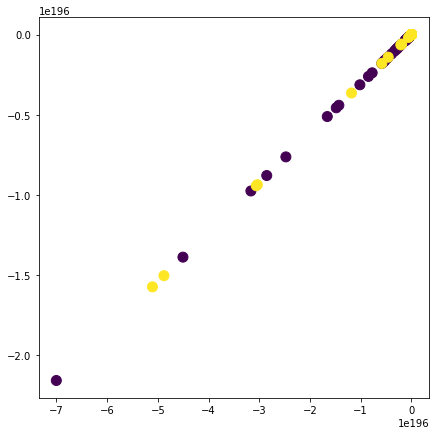

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(drawing[:, 0], drawing[:, 1], c=drawing[:, 2], s=100)
plt.show()